In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

import time
from kmodes.kprototypes import KPrototypes

import pickle

In [2]:
sns.set(rc={'figure.figsize':(10,5)})

In [3]:
CENSUS_PATH = 'data/refined/census_data.parquet'

CUSTOMER_PATH = 'data/refined/customer_data.parquet'

In [18]:
census = pd.read_parquet(CENSUS_PATH)

In [5]:
census.head()

,LNR,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,...,KBA13_ALTERHALTER_45,KBA13_SEG_VAN,KBA13_BJ_2004,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET
1,910220,11.0,0.0,2.0,0.0,963.0,1992.0,0.0,0.0,0.0,...,2.0,4.0,3.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0
2,910225,10.0,0.0,1.0,0.0,712.0,1992.0,0.0,0.0,0.0,...,2.0,3.0,4.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0
3,910226,1.0,0.0,0.0,0.0,596.0,1997.0,0.0,0.0,0.0,...,3.0,4.0,3.0,4.0,2.0,6.0,4.0,3.0,4.0,1.0
4,910241,3.0,0.0,4.0,0.0,435.0,1992.0,1.0,1.0,0.0,...,3.0,2.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0
5,910244,5.0,0.0,1.0,0.0,1300.0,1992.0,0.0,0.0,0.0,...,4.0,4.0,3.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0


In [6]:
census_var_types = pd.read_csv('data/trusted/census_var_types.csv').drop(columns='Unnamed: 0')

In [7]:
census_var_types.head()

,Attribute,Type
0,ALTERSKATEGORIE_GROB,interval
1,ANREDE_KZ,binary
2,ANZ_HAUSHALTE_AKTIV,numeric
3,ANZ_HH_TITEL,numeric
4,ANZ_PERSONEN,numeric


In [8]:
census_var_types.loc[census_var_types['Attribute'] == 'ANZ_HH_TITEL','Type'] = 'binary'

In [9]:
census.shape

(784908, 172)

In [10]:
census_var_types['Type'].value_counts()

interval    166
nominal      14
numeric       7
binary        6
Name: Type, dtype: int64

Variables considered as interval could be used in PCA. Unfortunately, this approach is not enough to handle nominal and binary features.  
An alteranitve approach to solve this problem is [Factorial Analysis of Mixed Data (FAMD)](https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210).  
Using this approach, we will reduce the dimensions of the mixed data types prior to clustering it.

# Clustering demographic data

## Adjustments to nominals and binaries

In [11]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, census.columns)

In [12]:
for col in binary_vars:
    
    try:
        print(col, census[col].unique())

    except:

        print(f'Column not found: {col}')

        continue

ANREDE_KZ [2 1]
ANZ_HH_TITEL [0. 1.]
GREEN_AVANTGARDE [0 1]
OST_WEST_KZ [1. 0.]
VERS_TYP [2. 1.]


In [13]:
census['ANREDE_KZ'] = census['ANREDE_KZ'] - 1

census['VERS_TYP'] = census['VERS_TYP'] - 1

In [19]:
is_subset = True

if is_subset:

    with open('data/trusted/selected_features.pkl', 'rb') as file:

        selected_features = pickle.load(file)
    
    selected_features.append('LNR')

    census = census[selected_features].copy()

In [20]:
nominal_vars = census_var_types[census_var_types['Type'] == 'nominal']['Attribute'].values

nominal_vars = np.intersect1d(nominal_vars, census.columns)

In [21]:
interval_vars = census_var_types[census_var_types['Type'] == 'interval']['Attribute'].values

interval_vars = np.intersect1d(interval_vars, census.columns)

In [22]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, census.columns)

In [23]:
num_cols = census.columns.drop(list(nominal_vars) + list(binary_vars) + list(interval_vars) + ['LNR'])

In [26]:
assert (len(nominal_vars) + len(binary_vars) + len(interval_vars) + len(num_cols) + 1) == census.shape[1]

# PCA + KMeans
FAMD Application

In [27]:
census = pd.get_dummies(census, columns=list(nominal_vars))

In [28]:
dummy_nominal_vars = []

for name in list(nominal_vars):

    for col in census.columns:

        if name in col:

            dummy_nominal_vars.append(col)

# Fix for GEBAEUDETYP and GEBAUDETYP_RASTER
dummy_nominal_vars = sorted(list(set(dummy_nominal_vars)))

In [29]:
def weight_encoded_col(col):

    # mean = probability of occurance for a binary col
    mean = col.mean()

    weight = np.sqrt(mean)

    col = col / weight
    
    # Centering
    center_ref = col.mean()

    col = col - center_ref
    
    return col

In [30]:
for col in list(binary_vars) + list(dummy_nominal_vars):

    census[col] = weight_encoded_col(census[col])

## Numerical columns

In [31]:
num_col_list = census.columns.drop(list(binary_vars) + dummy_nominal_vars + ['LNR'])

In [32]:
scaler = StandardScaler()

In [33]:
census[num_col_list] = scaler.fit_transform(census[num_col_list])

# PCA

In [34]:
census.shape

(784908, 105)

In [35]:
explained_var_list_step_2 = []

for comp in range(20,100, 20):

    print(f'Running for {comp} components...')
    pca = PCA(n_components=comp, random_state=123)

    pca.fit(census.drop(columns = 'LNR'))

    expl_variance = pca.explained_variance_ratio_.sum()

    print(f'Explained Variance: {expl_variance}', end = '\n\n')
    
    explained_var_list_step_2.append(expl_variance)

    if expl_variance >= 0.95:

        break
    # explained_var_list.append(explained_var_list_step_2)

Running for 20 components...
Explained Variance: 0.5790538237983482

Running for 40 components...
Explained Variance: 0.7848555044809882

Running for 60 components...
Explained Variance: 0.9221030932841603

Running for 80 components...
Explained Variance: 0.98239744905113



# K-Means

800k entries is too much for some machines to handle and/or take a long time for the algorithm to run.  
Therefore, assuming the AZDIAS data as the population we want to model for, we will use a sample of it to find the centroids of our clusters to then propagate this information.  
Using a simple [Sample Size Calculator](https://www.calculator.net/sample-size-calculator.html?type=1&cl=99.9&ci=1&pp=50&ps=891221&x=0&y=0), assuming a homogenous population, we find that for a confidence level of 99.9% and 1% margin of error, we can have approx. 26k points to model this population. 
To round up, we sample 30.000 points

In [36]:
def score_kmeans(X,k_range):

    for i, k in enumerate(k_range):

        print(f'Running for K = {k} Clusters...')

        # Using MiniBatch for performance
        kmeans = MiniBatchKMeans(n_clusters=k,
                                    init = 'k-means++',
                                    random_state=123,
                                    batch_size=2048,
                                    max_iter=50,
                                    n_init = 3)

        clusters = kmeans.fit_predict(X)

        score = silhouette_score(X, clusters)

        print(f'Silhouette score of: {score}', end = '\n\n')

        if i == 0:

            silhouette_list = [score]

            dist_list = [kmeans.inertia_]
        
        else:

            silhouette_list.append(score)

            dist_list.append(kmeans.inertia_)

    return silhouette_list, dist_list

In [37]:
pca = PCA(n_components=70, random_state=123)

pca.fit(census.drop(columns = 'LNR'))

X = pca.transform(census.drop(columns = 'LNR'))

In [73]:
# Offloading memory
# del census

In [38]:
rng = np.random.default_rng()

# Reproducibility
np.random.seed = 123

X_sample = rng.choice(X, size = 10000, replace = False)

In [39]:
k_range = range(2,11)

In [40]:
sample_30k_silhouette, sample_30k_distances = score_kmeans(X_sample, k_range)

Running for K = 2 Clusters...
Silhouette score of: 0.11528387301680645

Running for K = 3 Clusters...
Silhouette score of: 0.10101108878643052

Running for K = 4 Clusters...
Silhouette score of: 0.06254323963347513

Running for K = 5 Clusters...
Silhouette score of: 0.049825699674288806

Running for K = 6 Clusters...
Silhouette score of: 0.05152979385650447

Running for K = 7 Clusters...
Silhouette score of: 0.04630318310686655

Running for K = 8 Clusters...
Silhouette score of: 0.04130596803448616

Running for K = 9 Clusters...
Silhouette score of: 0.04819080386100841

Running for K = 10 Clusters...
Silhouette score of: 0.04470643610025433



<AxesSubplot: >

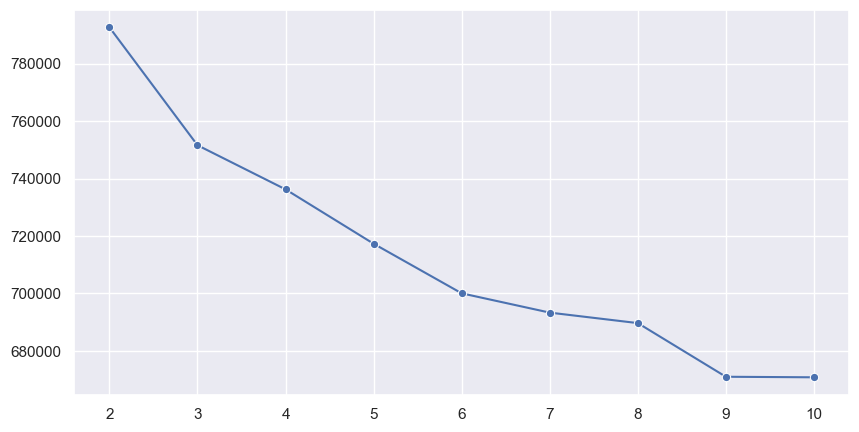

In [44]:
sns.lineplot(x = range(2,11), y = sample_30k_distances, marker = 'o')